In [43]:
import seaborn as sns
import numpy as np
import pandas as pd

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

In [ ]:
with open('preprocessed.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)
    print(len(data))

# Use another file than the preprocessed.pkl
with open('preprocessed_data/female_self_data.pkl', 'rb') as f:
    female_data = pickle.load(f)
    print(female_data)
    print(len(female_data))

      has_null  wave  gender   age  age_o  d_age  d_d_age  race  race_o  \
0            0   1.0       0  21.0   27.0    6.0        2     0       2   
1            0   1.0       0  21.0   22.0    1.0        0     0       2   
2            1   1.0       0  21.0   22.0    1.0        0     0       0   
3            0   1.0       0  21.0   23.0    2.0        1     0       2   
4            0   1.0       0  21.0   24.0    3.0        1     0       3   
...        ...   ...     ...   ...    ...    ...      ...   ...     ...   
8373         1  21.0       1  25.0   26.0    1.0        0     2       3   
8374         1  21.0       1  25.0   24.0    1.0        0     2       4   
8375         1  21.0       1  25.0   29.0    4.0        2     2       3   
8376         1  21.0       1  25.0   22.0    3.0        1     2       0   
8377         1  21.0       1  25.0   22.0    3.0        1     2       0   

      samerace  ...  d_expected_num_interested_in_me  d_expected_num_matches  \
0            0  ...

#### Show correlation between self-reported scores and scores given by the opponent 

              attractive  attractive_o
attractive      1.000000      0.287271
attractive_o    0.287271      1.000000
            sincere  sinsere_o
sincere    1.000000  -0.007687
sinsere_o -0.007687   1.000000
            funny   funny_o
funny    1.000000 -0.050144
funny_o -0.050144  1.000000
            ambition  ambitous_o
ambition    1.000000    0.157387
ambitous_o  0.157387    1.000000
                intelligence  intelligence_o
intelligence        1.000000       -0.055194
intelligence_o     -0.055194        1.000000


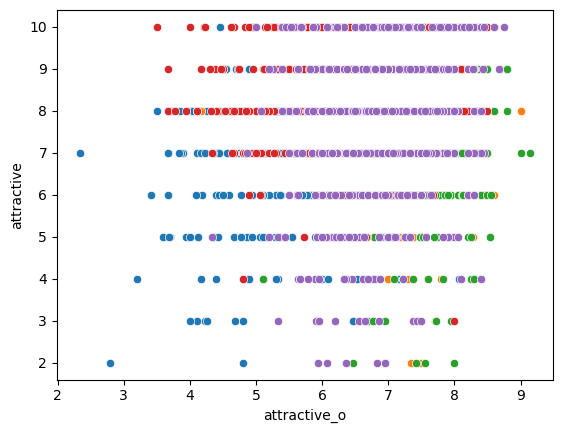

In [45]:
self_rated_features = ['attractive', 'sincere', 'intelligence', 'funny', 'ambition']
average_columns = [ 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o']
group_by_columns = ['gender', 'age', 'race', 'field', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']

def compare_ratings(data):
    combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
    )
    reduced_df = combined_df[self_rated_features + average_columns]
    
    corr_attractive = reduced_df[['attractive', 'attractive_o']].corr()
    corr_sincere = reduced_df[['sincere', 'sinsere_o']].corr()
    corr_intelligence = reduced_df[['intelligence', 'intelligence_o']].corr()
    corr_funny = reduced_df[['funny', 'funny_o']].corr()
    corr_ambition = reduced_df[['ambition', 'ambitous_o']].corr()
    
    print(corr_attractive)
    print(corr_sincere)
    print(corr_funny)
    print(corr_ambition)
    print(corr_intelligence)
    
    sns.scatterplot(reduced_df, x="attractive_o", y="attractive")
    sns.scatterplot(reduced_df, x="sinsere_o", y="sincere")
    sns.scatterplot(reduced_df, x="intelligence_o", y="intelligence")
    sns.scatterplot(reduced_df, x="funny_o", y="funny")
    sns.scatterplot(reduced_df, x="ambitous_o", y="ambition")  
   
    
compare_ratings(data)     
    

In [46]:
def remove_relational_data(data):
    data = data[['gender', 'age', 'race', 'field', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'shared_interests_o']]
    return data

data = remove_relational_data(data)    

In [47]:
combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
)

In [48]:
# Select women
# combined_df = combined_df.loc[combined_df['gender'] == 0]
combined_df = female_data # Use another file than the preprocessed.pkl

# Select men
#combined_df = combined_df.loc[combined_df['gender'] == 1]

##### Normalize features

In [49]:
#Remove categorical values
features = combined_df.drop(labels=['race', 'field'], axis=1)

# Normalize the data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

##### Apply PCA

In [50]:
n_reduced_features = []
for n in range(2,10):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(normalized_features)
    n_reduced_features.append(reduced_features)
    print('Cumulative variance explained by {} principal components: {:.2%}'.format(n, np.sum(pca.explained_variance_ratio_)))


Cumulative variance explained by 2 principal components: 21.47%
Cumulative variance explained by 3 principal components: 29.83%
Cumulative variance explained by 4 principal components: 36.64%
Cumulative variance explained by 5 principal components: 42.68%
Cumulative variance explained by 6 principal components: 47.39%
Cumulative variance explained by 7 principal components: 51.80%
Cumulative variance explained by 8 principal components: 55.59%
Cumulative variance explained by 9 principal components: 59.14%


### K-means - Partitional Clustering Techniques

#### Generalized fitting and tuning function

In [55]:
def tune_model(parameter_grid, model, data, show_silhouette, show_inertia_distortion):
    if show_inertia_distortion:
        distortions = []
        inertias = []
        
        mapping1=  {}  
        mapping2=  {}    

    best_score = -1        
    silhouette_scores = []
    
    # evaluation based on silhouette_score
    for p in parameter_grid:
        model.set_params(**p)    # Set current hyperparameters
        model.fit(data) 
        
        if len(set(model.labels_)) > 2:
            ss = silhouette_score(data, model.labels_)   
            silhouette_scores += [ss]     
            if show_silhouette:
                print('Parameter:', p, 'Score', ss)
            
            if show_inertia_distortion:
                distortions.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)**2) / data.shape[0])      
                inertias.append(model.inertia_)
            
                k = p['n_clusters']
                # Store the mappings for easy access
                mapping1[k] = distortions[-1]
                mapping2[k] = inertias[-1]
                # check p which has the best score
            
            if ss > best_score:
                best_score = ss
                best_grid = p
        
    if show_silhouette:      
        # plotting silhouette score
        plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
        # plt.xticks(range(len(silhouette_scores)), range(len(list(silhouette_scores))))
        plt.xticks(range(len(silhouette_scores)), range(3, 15)) # modify the display
        plt.title('K-means', fontweight='bold') # modify the display
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score') # modify the display
        plt.show()
    
    if show_inertia_distortion:
        print("Distortion values:")
        for key, val in mapping1.items():
            print(f'{key} : {val}')
        # Plotting the graph of k versus Distortion
        plt.plot(parameters, distortions, 'bx-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.grid()
        plt.show()
        
        print("Inertia values:")
        for key, val in mapping2.items():
            print(f'{key} : {val}')
        # Plotting the graph of k versus Inertia
        plt.plot(parameters, inertias, 'bx-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.grid()
        plt.show()   

d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarn

Parameter: {'n_clusters': 3, 'n_init': 'auto'} Score 0.06128785997809865
Parameter: {'n_clusters': 4, 'n_init': 'auto'} Score 0.05732297257597812
Parameter: {'n_clusters': 5, 'n_init': 'auto'} Score 0.03911718769992455
Parameter: {'n_clusters': 6, 'n_init': 'auto'} Score 0.04944877893589848
Parameter: {'n_clusters': 7, 'n_init': 'auto'} Score 0.03576281361630149
Parameter: {'n_clusters': 8, 'n_init': 'auto'} Score 0.04174940856909216
Parameter: {'n_clusters': 9, 'n_init': 'auto'} Score 0.016296582338045852
Parameter: {'n_clusters': 10, 'n_init': 'auto'} Score 0.039193770077850944
Parameter: {'n_clusters': 11, 'n_init': 'auto'} Score 0.03431120447386333
Parameter: {'n_clusters': 12, 'n_init': 'auto'} Score 0.0273852594878206
Parameter: {'n_clusters': 13, 'n_init': 'auto'} Score 0.027006842910084015
Parameter: {'n_clusters': 14, 'n_init': 'auto'} Score 0.031941655159445304


d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


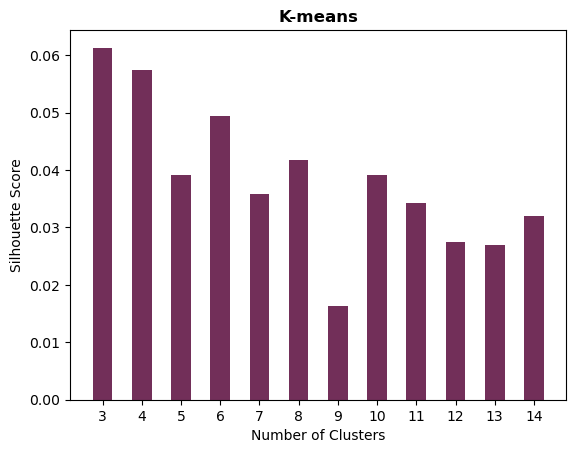

d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarn

In [56]:
model = KMeans()
parameters = range(2,15)
parameter_grid = ParameterGrid({'n_clusters': parameters, 'n_init': ['auto']})

tune_model(parameter_grid, model, combined_df, False, False)
tune_model(parameter_grid, model, normalized_features, True, False)
for rf in n_reduced_features:
    tune_model(parameter_grid, model, rf, False, False)

### Hierarchical Clustering

Parameter: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 5} Score 0.2694992492606316
Parameter: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 10} Score 0.2038208815383708
Parameter: {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 5} Score 0.364042749396879
Parameter: {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 10} Score 0.29391098653798137
Parameter: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 5} Score 0.3707230309133099
Parameter: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 10} Score 0.277860680098177


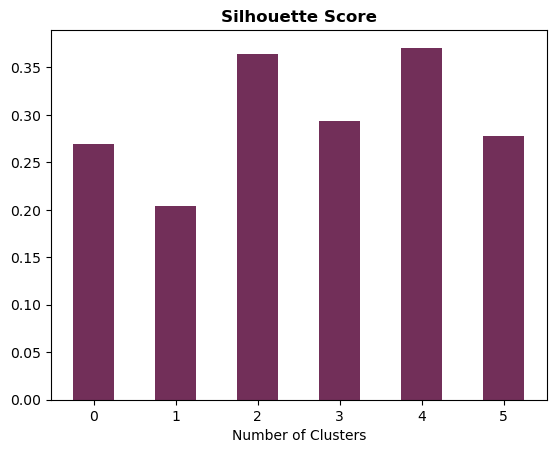

Parameter: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 5} Score 0.029958932840754883
Parameter: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 10} Score 0.01297792497629097
Parameter: {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 5} Score 0.03611158357136431
Parameter: {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 10} Score 0.01246968920103768
Parameter: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 5} Score 0.24370045186261463
Parameter: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 10} Score 0.1175544119230698


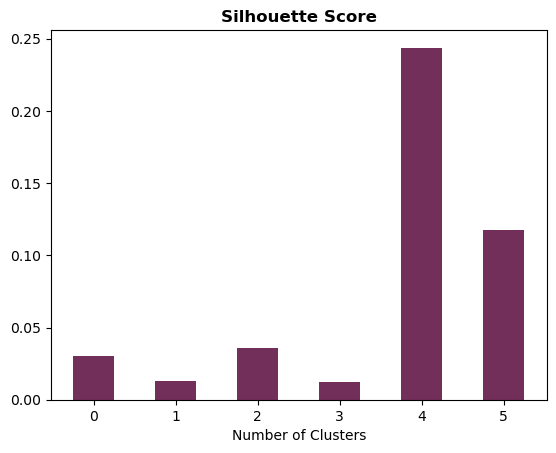

In [11]:
parameters = [2, 5, 10]
parameter_grid = ParameterGrid({'n_clusters': parameters, 'metric': ['euclidean'], 'linkage':['ward', 'complete', 'average']})
agglom = AgglomerativeClustering() 

tune_model(parameter_grid, agglom, combined_df, True, False)
tune_model(parameter_grid, agglom, normalized_features, True, False)


### DBSCAN

Parameter: {'eps': 10, 'min_samples': 2} Score -0.5598662925503144
Parameter: {'eps': 20, 'min_samples': 2} Score -0.015953629333779126
Parameter: {'eps': 20, 'min_samples': 5} Score 0.29478295773361946
Parameter: {'eps': 20, 'min_samples': 10} Score 0.02752944840039299


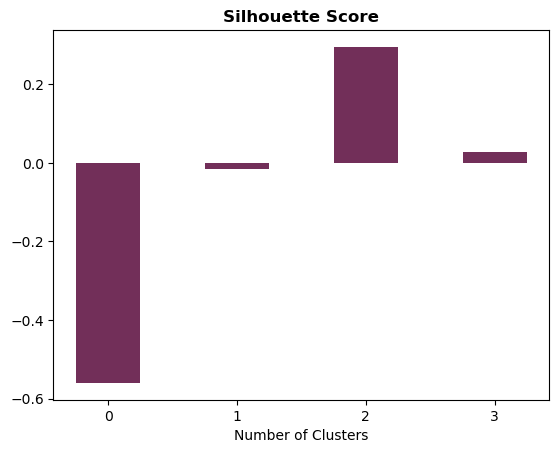

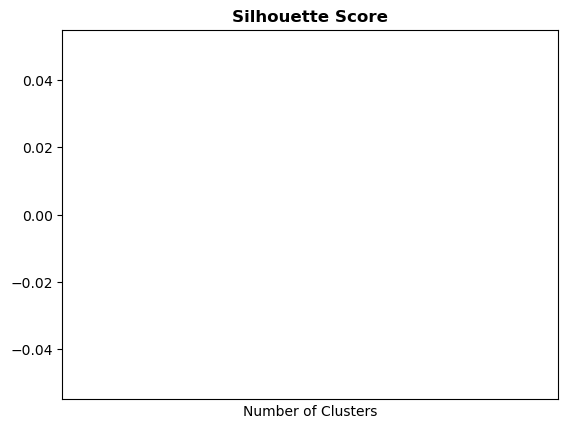

In [12]:
dbscan = DBSCAN()
eps = [0.01, 0.2, 0.5, 0.9, 1, 10, 20, 100]
min_samples = [2, 5, 10]

parameter_grid = ParameterGrid({'eps':eps, 'min_samples':min_samples})

tune_model(parameter_grid, dbscan, combined_df, True, False)
tune_model(parameter_grid, dbscan, normalized_features, True, False)

